In [1]:
import time
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from mlrose_hiive import NeuralNetwork
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import precision_recall_curve, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler

## Preparing Data

In [2]:
# Read cvs data in the "data" folder (due to limitation of github, the data is seperated to two parts)
raw_df1 = pd.read_csv('data/creditcard1.csv')
raw_df2 = pd.read_csv('data/creditcard2.csv')
raw_df = pd.concat([raw_df1, raw_df2])

In [3]:
# The classes are heavily skewed
print('No Frauds', round(raw_df['Class'].value_counts()[0]/len(raw_df) * 100,2), '% of the dataset')
print('Frauds', round(raw_df['Class'].value_counts()[1]/len(raw_df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [4]:
# RobustScaler is less prone to outliers.

# std_scaler = StandardScaler()
rob_scaler = RobustScaler()

raw_df['scaled_amount'] = rob_scaler.fit_transform(raw_df['Amount'].values.reshape(-1,1))
raw_df['scaled_time'] = rob_scaler.fit_transform(raw_df['Time'].values.reshape(-1,1))

raw_df.drop(['Time','Amount'], axis=1, inplace=True)

In [5]:
train_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=1, stratify=raw_df['Class'])
# train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=10, stratify=train_val_df['Class'])

In [6]:
# Handle imbalance data for the training data only: Random Under Sampling
#  Creating a new sub-sample with balance number of fraud and non-fraud
fraud_df = train_df.loc[train_df['Class'] == 1]
non_fraud_df = train_df.loc[train_df['Class'] == 0][:fraud_df.shape[0]]
new_df = pd.concat([fraud_df, non_fraud_df])
train_df = new_df.sample(frac=1, random_state=1)

In [7]:
y_train = train_df.pop('Class').values
# y_val = val_df.pop('Class').values
y_test = test_df.pop('Class').values
X_train = train_df
X_test = test_df

In [8]:
X_train.shape

(788, 30)

## Defining Models

In [9]:
# NeuralNetwork

In [10]:
def nn_model(algorithm):
     return NeuralNetwork(hidden_nodes=[2,2], activation='tanh', 
                            algorithm=algorithm, max_iters=1000, is_classifier=True, 
                            learning_rate=0.1, early_stopping=False, random_state=1, curve=True)

In [11]:
rhc_model = nn_model('random_hill_climb')
sa_model = nn_model('simulated_annealing')
ga_model = nn_model('genetic_alg')
listed_models = [rhc_model, sa_model, ga_model]
model_name = ['rhc', 'sa', 'ga']

In [12]:
%%time
fitted_models = []
fitted_time = []

for model in listed_models:
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    fitted_models.append(model)
    fitted_time.append(end-start)

CPU times: total: 2min 9s
Wall time: 2min 9s


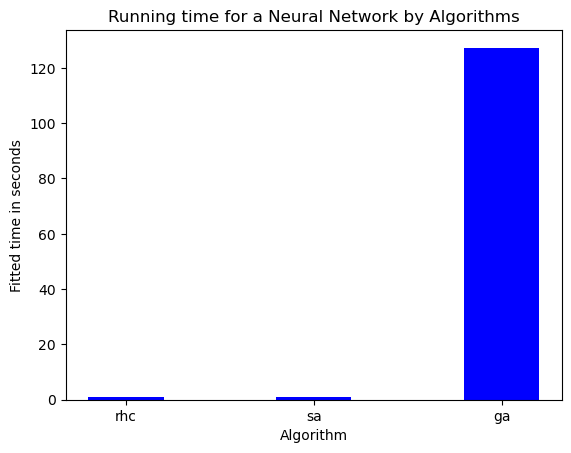

In [13]:
# Plot fitted time for each Algorithm
plt.bar(model_name, fitted_time, color ='blue', width = 0.4)
plt.xlabel("Algorithm")
plt.ylabel("Fitted time in seconds")
plt.title("Running time for a Neural Network by Algorithms")
plt.savefig('image/fitted_time')
plt.show()

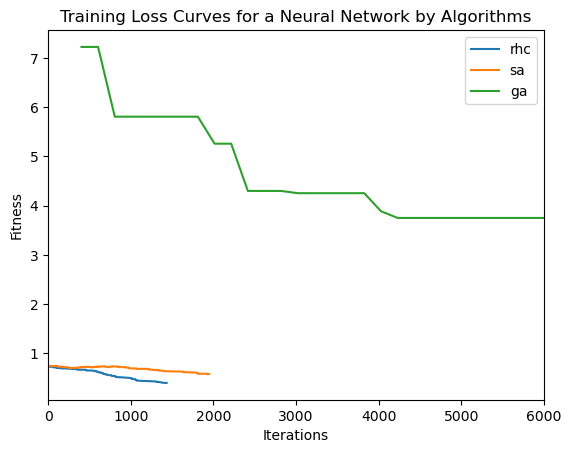

In [14]:
# Plot fitness curve
for i in range(len(fitted_models)):
    plt.plot(fitted_models[i].fitness_curve[:,1], fitted_models[i].fitness_curve[:,0], label=model_name[i])
plt.xlim([0, 6000])
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.title("Training Loss Curves for a Neural Network by Algorithms")
plt.legend()

plt.savefig('image/fitness_curve')

plt.show()

In [15]:
train_recall_score = []
test_recall_score = []
for model in fitted_models:
    train_recall_score.append(recall_score(y_train, model.predict(X_train)))
    test_recall_score.append(recall_score(y_test, model.predict(X_test)))

In [16]:
# recall_score(y_train, fitted_models[0].predict(X_train))
# fitted_models[0].predict(X_train)

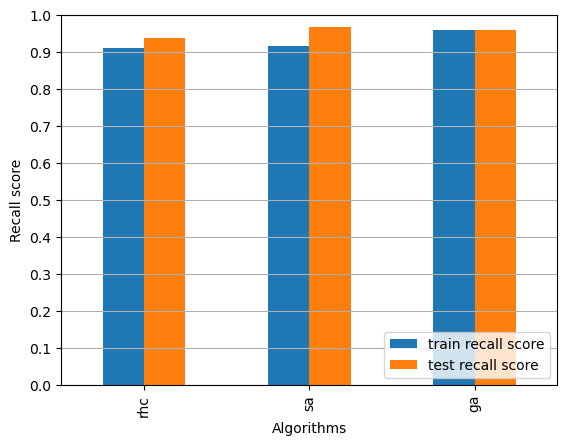

In [17]:
# Plot evaluation scores
recall_score = pd.DataFrame(data=zip(train_recall_score, test_recall_score), index=model_name, 
                            columns=['train recall score', 'test recall score'])
recall_score.plot.bar()
plt.ylim([0.,1.])
plt.xlabel('Algorithms')
plt.ylabel('Recall score')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.savefig('image/recall_score.png')
plt.legend(loc='lower right')
plt.grid(which='both', axis='y')
plt.show()

In [18]:
train_recall_score

[0.9111675126903553, 0.916243654822335, 0.9593908629441624]

In [19]:
test_recall_score

[0.9387755102040817, 0.9693877551020408, 0.9591836734693877]

In [20]:
print(confusion_matrix(y_train, fitted_models[0].predict(X_train)))

[[359  35]
 [ 35 359]]


In [21]:
print(confusion_matrix(y_test, fitted_models[0].predict(X_test)))

[[50402  6462]
 [    6    92]]
